<a href="https://colab.research.google.com/github/itayhorin/Notebooks/blob/main/EfficiencyForDetector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%pylab inline
from scipy.stats import rv_histogram
import pandas

Populating the interactive namespace from numpy and matplotlib


In [2]:
## geometry properties
##     Z             R

## -32.5 -17.5   (15)   6.4
##  -17.5 17.5   (35)  10.7
##  17.5 37.5    (20)   6.4

In [3]:
# normalize yield probabillty according to area of each surface

In [2]:
Areas = array([15*6.4,35*10.7,20*6.4])*2*pi
probs = Areas / sum(Areas)

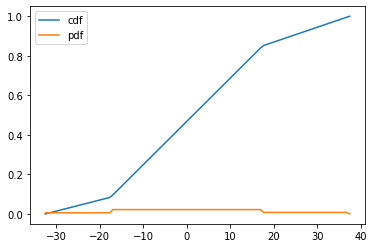

In [3]:
# creating the distribution over Z - axis
bins = array([0,15,50,70])-32.5
my_dist = rv_histogram((probs,bins))
X = linspace(bins[0],bins[-1],100)
plot(X,my_dist.cdf(X) , label = 'cdf')
plot(X,my_dist.pdf(X) , label = 'pdf')
legend()

In [4]:
n = 10000  # number of patricles 

## creating position (from geometry) and 
z = my_dist.rvs(size = n)
theta = rand(n)*2*pi 
x = where( (-17.5<=z) &  (z<=17.5) , 10.7*cos(z) , 6.4*cos(z))
y = where( (-17.5<=z) &  (z<=17.5), 10.7*sin(z) , 6.4*sin(z))
i = rand(n)
j = rand(n)
theta_v = 2*pi*i
phi = arccos(2*j-1)

P = pandas.DataFrame(data = array([x,y,z]).T ) # columns = ['x' , 'y' , 'z']



In [5]:
# det propeties
Normal = array([0,1,0])
R = 29.6
p_plane = pandas.DataFrame(data = [[0,55.5,0]]*n )

In [6]:
def ReachedFrom(P):




#velocity (isotropic) of each particle
  v1 = cos(theta_v)*sin(phi)
  v2 = sin(theta_v)*sin(phi)
  v3 = cos(phi)
  V = pandas.DataFrame(data = array([v1,v2,v3]).T )

# time of arrival
  t = ( (p_plane-P).dot(Normal) )/ (V.dot(Normal))

# advance particles in time
  V[0] = V[0]*t
  V[1] = V[1]*t
  V[2] = V[2]*t

  

  L = P + V  # end position of particle
  
  # more properties of end position
  L['R_xz'] = ( L[0]**2 + L[2]**2 )**0.5
  L["t"] = t
   
  # particle needs to be inside the det space  
  RD = L.query("R_xz <= @R and t > 0")
  
  return RD #particles reached det


In [7]:
def thetaOfArrival(P):
  # using dot product to find the angle which the particle arrived to det (angle w.r.t normal and the normal of plane)

  W =  ( (ReachedFrom(P)-P)[[0,1,2]] ).dropna(how = 'all')
  WdotN = W.dot(Normal) 
  W['norm'] = (W[0]**2 + W[1]**2 + W[2]**2 )**0.5
  return  arccos(WdotN/W['norm'])


In [8]:
p_origin = pandas.DataFrame(data = [[0,0,0]]*n )

In [9]:
U1 = rand(n)
U2 = rand(n)
r = 1
x = r * np.sqrt(U2) * np.cos(2 * np.pi * U1)
y = U1*0
z = r * np.sqrt(U2) * np.sin(2 * np.pi * U1)
p_origin_disk  = pandas.DataFrame(data = array([x,y,z]).T )

In [10]:
ratio1 = ReachedFrom(P).shape[0] / ReachedFrom(p_origin).shape[0] 
ratio2 = ReachedFrom(P).shape[0] / ReachedFrom(p_origin_disk).shape[0] 
print(ratio1 , ratio2)

0.9101307189542484 0.9161184210526315


9.508450530954365
21.3702592834975


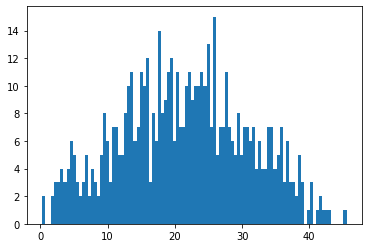

In [11]:
S1 = thetaOfArrival(P)*180/pi
hist(S1 , bins = 100);
print(S1.std())
print(S1.mean())

6.661204041021864
18.56950035079507


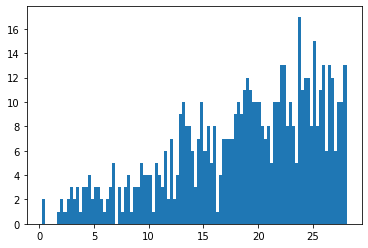

In [12]:
S2 = thetaOfArrival(p_origin)*180/pi
hist(S2 , bins = 100);
print(S2.std())
print(S2.mean())

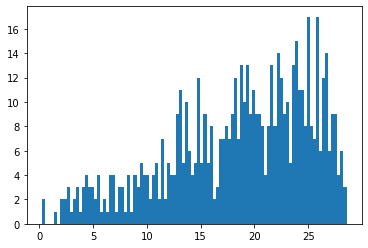

In [13]:
S3 = thetaOfArrival(p_origin_disk)*180/pi
hist(S3 , bins = 100);

In [14]:
import scipy

In [103]:
n = 100
P = p_origin = pandas.DataFrame(data = [[0,0,0]]*n )
P_f = ReachedFrom(P)
thickness = 1
def F(r):
  x,y,z = r.values.T
  R = sqrt(x**2+y**2)
  return  where( \
        ( (-32.5 <= z) & (z<= -17.5) & (6.4 <= R) & (R<= 6.4 + thickness)  ) | \
        ( (-17.5 <= z) & (z<= 17.5) & (10.7 <= R) & (R<= 10.7 + thickness) ) |  \
        ( (17.5 <= z) & (z<= 37.5)  &  (6.4 <= R) & (R<= 6.4 + thickness) ) \
        , 1 , 0 )
 # if   ( (-32.5 <= z <= -17.5) and (6.4 <= sqrt(x**2 + y**2) <= 6.5)   ) or \
 #      ( (-17.5 <= z <= 17.5) and (10.7 <= sqrt(x**2 + y**2) <= 10.8)  )  or \
  #     ( (17.5 <= z <= 37.5) and   (6.4 <= sqrt(x**2 + y**2) <= 6.5)  ):
  #     return 1
  #else:
   # return 0

def r(t):
  return (P + ( (P_f-P)[[0,1,2]] ) * t).dropna(how = 'all')

def integrand(t):   # array of zero or one (indicator for which patricle is in det space), each index is a particle. t is the advance in time (scaled to 1)
  return F(r(t))


#[scipy.integrate.quad(lambda t: integrand(t)[i], 0, 1 , full_output = 1)[0] for i in arange(P_f.shape[0]) ]
relD = scipy.integrate.quad_vec(lambda t: integrand(t), 0, 1 , points = [0.1,0.3])[0]

In [69]:
D = sqrt((((P_f-P)[[0,1,2]].dropna(how = 'all'))**2).sum(axis = 1))

In [107]:
widths = relD * D

In [108]:
widths.mean()

1.0227148577389644